In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb


# pip install lightning torchmetrics
import torch, torch.nn as nn
torch.set_float32_matmul_precision("high")
from torch.utils.data import TensorDataset, DataLoader
import lightning as L
from torchmetrics.regression import MeanSquaredError, R2Score

from plot_utils import plot_temperature_sequences


### 1. Load data

In [2]:
X_train_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/processed/X_train.npy"
y_train_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/processed/y_train.npy"

X_val_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/processed/X_val.npy"
y_val_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/processed/y_val.npy"

X_test_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/processed/X_test.npy"
y_test_dir = "/home/obola/repositories/cicero-scm-surrogate/data/20250926_110035/processed/y_test.npy"

X_train = np.load(X_train_dir)
y_train = np.load(y_train_dir)

X_val = np.load(X_val_dir)
y_val = np.load(y_val_dir)

X_test = np.load(X_test_dir)
y_test = np.load(y_test_dir)


In [5]:
X_train.shape, X_val.shape, X_test.shape

((854000, 66, 40), (183000, 66, 40), (183000, 66, 40))

### 2. SK-learn pipeline

In [3]:
# Example: flatten input
def flatten_X(X):
    return X.reshape(X.shape[0], -1)

# Flatten
X_train_flat = flatten_X(X_train)
X_val_flat = flatten_X(X_val)
X_test_flat = flatten_X(X_test)

### 2.1 Linear regression

In [ ]:
linreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])

linreg_pipeline.fit(X_train_flat, y_train)

y_pred_val_lr = linreg_pipeline.predict(X_val_flat)
r2_val_lr = r2_score(y_val, y_pred_val_lr)
rmse_val_lr = np.sqrt(mean_squared_error(y_val, y_pred_val_lr))
print(f"Linear Regression Validation R2: {r2_val_lr:.4f}")
print(f"Linear Regression Validation RMSE: {rmse_val_lr:.4f}")

Linear Regression Test R2: 0.9767
Linear Regression Test RMSE: 0.0364


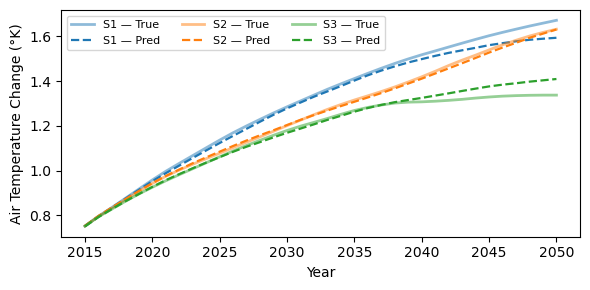

In [ ]:
y_pred_test_lr = linreg_pipeline.predict(X_test_flat)
r2_test_lr = r2_score(y_test, y_pred_test_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_test_lr))
print(f"Linear Regression Test R2: {r2_test_lr:.4f}")
print(f"Linear Regression Test RMSE: {rmse_test_lr:.4f}")

plot_temperature_sequences(y_test, y_pred_test_lr, seq_len=36, n_samples=3, seed=4,
                   years=np.arange(2015, 2015+36), 
                   savepath="plots/test_seq_lr.pdf")

### 2.2 XG boost

In [ ]:
xgb_rf = xgb.XGBRegressor(
    n_estimators=400,          
    max_depth=8,               
    subsample=0.7,
    colsample_bytree=0.5,
    colsample_bylevel=0.7,
    max_bin=128,               
    grow_policy="depthwise",   
    tree_method="hist",
    device="cuda",
    random_state=0
)

xgb_rf.fit(X_train_flat, y_train)

y_pred_val_xg = xgb_rf.predict(X_val_flat)

r2_val_xg = r2_score(y_val, y_pred_val_xg)
rmse_val_xg = np.sqrt(mean_squared_error(y_val, y_pred_val_xg))
print(f"XG R2: {r2_val_xg:.4f}")
print(f"XG RMSE: {rmse_val_xg:.4f}")

/home/obola/miniconda3/envs/cicero/lib/python3.10/site-packages/xgboost/core.py:729: UserWarning: [13:42:47] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


XG R2: 0.9934
XG RMSE: 0.0194


XG R2: 0.9928
XG RMSE: 0.0202


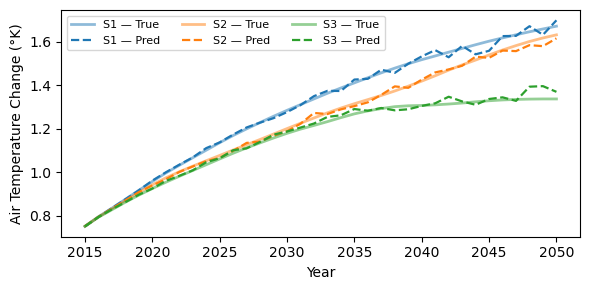

In [ ]:
y_pred_test_xg = xgb_rf.predict(X_test_flat)

r2_test_xg = r2_score(y_test, y_pred_test_xg)
rmse_test_xg = np.sqrt(mean_squared_error(y_test, y_pred_test_xg))
print(f"XG R2: {r2_test_xg:.4f}")
print(f"XG RMSE: {rmse_test_xg:.4f}")

plot_temperature_sequences(y_test, y_pred_test_xg, seq_len=36, n_samples=3, seed=4,
                   years=np.arange(2015, 2015+36), 
                   savepath="plots/test_seq_xg.pdf")

### 3. MLP

In [8]:
# --- standardize X ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)  # fit on train
X_val_scaled   = scaler.transform(X_val_flat)        # apply to val
X_test_scaled   = scaler.transform(X_test_flat)        # apply to test

# --- tensors ---
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
X_val_tensor = torch.from_numpy(X_val_scaled).float()
y_val_tensor = torch.from_numpy(y_val).float().view(-1, 1)
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(y_test).float().view(-1, 1)

# --- data loaders ---
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=1024,
    shuffle=True,
    num_workers=12
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=1024,
    shuffle=False,
    num_workers=12
)

test_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=1024,
    shuffle=False,
    num_workers=12
)

In [9]:
class MLP(L.LightningModule):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 512), nn.GELU(),
            nn.Linear(512, 128), nn.GELU(),
            nn.Linear(128, 1)
        )
        self.crit = nn.MSELoss()
        self.val_rmse = MeanSquaredError(squared=False)
        self.val_r2   = R2Score()
        self.save_hyperparameters()

    def forward(self, x):
        return self.net(x)

    def training_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self.crit(yhat, y)

        # log loss and LR
        lr = self.optimizers().param_groups[0]['lr']
        self.log("lr", lr, prog_bar=True, on_step=True, on_epoch=False)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, _):
        x, y = batch
        yhat = self(x)
        loss = self.crit(yhat, y)
        self.val_rmse.update(yhat, y)
        self.val_r2.update(yhat, y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        rmse = self.val_rmse.compute()
        r2   = self.val_r2.compute()
        self.log("val_rmse", rmse, prog_bar=True)
        self.log("val_r2",   r2,   prog_bar=True)
        self.val_rmse.reset()
        self.val_r2.reset()

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), lr=1e-3)
        sch = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode="min", factor=0.5, patience=5
        )
        return {"optimizer": opt, "lr_scheduler": {"scheduler": sch, "monitor": "val_loss"}}

In [10]:
model = MLP(in_dim=X_train_tensor.shape[1])

trainer = L.Trainer(
    max_epochs=50,
    accelerator="auto", devices=[0],
    log_every_n_steps=20
)

trainer.fit(model, train_loader, val_loader)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/obola/miniconda3/envs/cicero/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name     | Type             | Params | Mode 
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [11]:
model.eval()
device = model.device

y_true, y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        y_true.append(yb.numpy().ravel())
        y_pred.append(model(xb.to(device)).cpu().numpy().ravel())

y_true = np.concatenate(y_true)
y_pred_mlp = np.concatenate(y_pred)

rmse = np.sqrt(mean_squared_error(y_true, y_pred_mlp))
r2   = r2_score(y_true, y_pred_mlp)
print(f"Val RMSE: {rmse:.4f}  R²: {r2:.4f}")

Val RMSE: 0.0263  R²: 0.9879


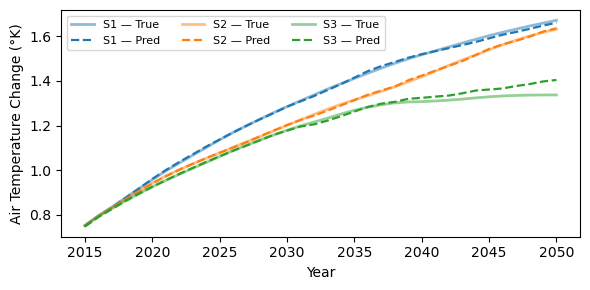

In [12]:
plot_temperature_sequences(y_true, y_pred_mlp, seq_len=36, n_samples=3, seed=4,
                   years=np.arange(2015, 2015+36), 
                   savepath="plots/test_seq_mlp.pdf")